In [3]:
from segmentation_models import Unet

In [4]:
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import pandas as pd
from keras.utils import to_categorical
#%%
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread

In [5]:
path_original = 'casia-20-image-tampering-detection-dataset/CASIA2/Au'
path_tampered = 'casia-20-image-tampering-detection-dataset/CASIA2/Tp'
path_ground = 'casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth'
#Downloads/image avni/path_to_extraction_directory/CASIA2/CASIA 2 Groundtruth/Tp_S_NRN_S_O_cha10126_cha10126_12153_gt.png
total_orig = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)
total_ground = os.listdir(path_ground)

In [6]:
from tqdm import tqdm
tamp_s = []
groundtruth_images = []
for file in tqdm(total_ground):       #choose all tampered images
    try:
        if file.endswith('png'):
                line = path_ground + '/' + file 
                groundtruth_images.append(line)

    except:
          print(total_ground+file)
        
for file in tqdm(total_tampered):       #choose all tampered images
    try:
        valid_extensions = ['jpg', 'tif', 'png']
        if file.endswith(tuple(valid_extensions)):
                line = path_tampered +'/'+ file 
                tamp_s.append(line)

    except:
          print(path_tampered+file)

100%|██████████| 5125/5125 [00:00<00:00, 1203572.68it/s]


In [7]:
def plot_ground_truth_mask(image,fake=True):
    PATH = image
    print(PATH)
    image = image[image.rfind('Tp'):-4] 
    PATH_mask = 'casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/' + image + "_gt.png"
    print(PATH_mask)
  #"C:\Users\dell\Downloads\image avni\path_to_extraction_directory\CASIA2\CASIA 2 Groundtruth\Tp_D_CND_S_N_ani00073_ani00068_00193_gt.png"  
    img = Image.open(PATH).convert("RGB")
    if image + "_gt.png" not in total_ground:
        print("no fo")
        return
    mask_img=Image.open(PATH_mask).convert("RGB")
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_title("Image")
    ax2.set_title("Ground Truth Mask")
    ax1.imshow(img)
    ax2.imshow(mask_img)

casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10168_ani10167_12448.jpg
casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/Tp_D_NRN_S_N_ani10168_ani10167_12448_gt.png


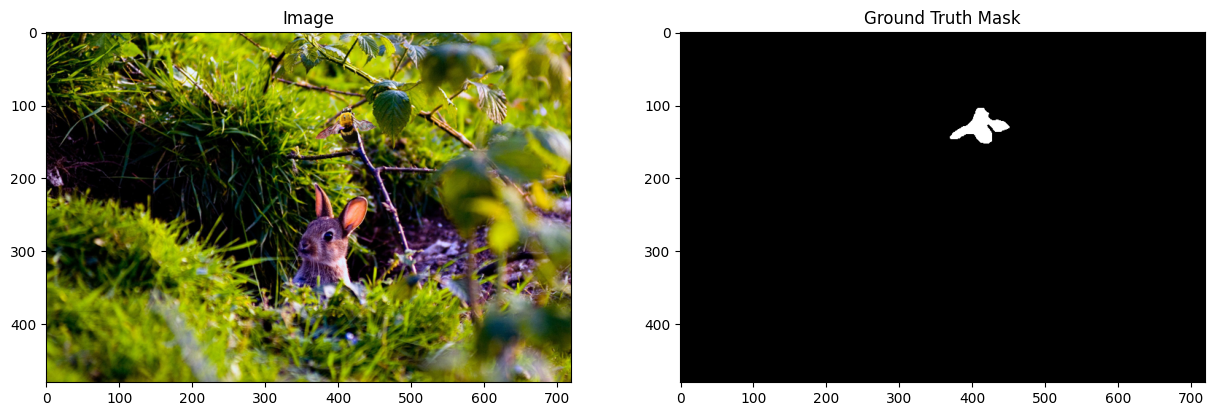

In [8]:
plot_ground_truth_mask(tamp_s[5030],fake=True)

In [9]:
def has_ground_truth(image):
    PATH = image
    image = image[image.rfind('Tp'):-4] 
    PATH_mask = 'casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth/' + image + "_gt.png"
    img = Image.open(PATH).convert("RGB")
    return PATH_mask in groundtruth_images   

In [10]:
tamp_image = [i for i in tamp_s if has_ground_truth(i)]

In [20]:
len(tamp_s)

5123

In [21]:
len(groundtruth_images)

5123

In [11]:
mask_image = sorted(groundtruth_images)
tamp_image = sorted(tamp_s)

In [12]:
def metric(y_true, y_pred, smooth=1): # Dice_Coeff or F-Score
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # Ensure both tensors are of the same type
    y_true_f = K.cast(y_true_f, dtype=tf.float32)
    y_pred_f = K.cast(y_pred_f, dtype=tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def LoadImages(batch):
    return np.array([resize(imread(file_name), (512, 512, 3)) for file_name in batch])
#https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset

def loadImagesBatchwise(X_train,Y_train, batch_size):
    train_image_files=X_train
    train_mask_files=Y_train
    L = len(train_image_files)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = LoadImages(train_image_files[batch_start:limit])
            Y = LoadImages(train_mask_files[batch_start:limit])
            print(f"Yielding batch from {start} to {end}")
            yield (X,Y)
            batch_start += batch_size
            batch_end += batch_size

In [24]:
#LoadImages(tamp_image)

array([[[[0.59007353, 0.66764706, 0.75968137],
         [0.5935049 , 0.67156863, 0.76311275],
         [0.59534314, 0.67340686, 0.76495098],
         ...,
         [0.58357843, 0.63541667, 0.62708333],
         [0.59093137, 0.64276961, 0.63406863],
         [0.5879902 , 0.63835784, 0.63112745]],

        [[0.59007353, 0.66764706, 0.75968137],
         [0.5935049 , 0.67156863, 0.76311275],
         [0.59534314, 0.67340686, 0.76495098],
         ...,
         [0.58357843, 0.63541667, 0.62708333],
         [0.59093137, 0.64276961, 0.63406863],
         [0.5879902 , 0.63835784, 0.63112745]],

        [[0.5692402 , 0.64509804, 0.73296569],
         [0.57561275, 0.65294118, 0.73933824],
         [0.58406863, 0.66139706, 0.74779412],
         ...,
         [0.60955882, 0.66605392, 0.63811275],
         [0.62573529, 0.68223039, 0.65318627],
         [0.6247549 , 0.6807598 , 0.65220588]],

        ...,

        [[0.12965686, 0.30220588, 0.10269608],
         [0.0875    , 0.26004902, 0.0625    ]

In [13]:
model = Unet('resnet101', input_shape=(512, 512, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')


model.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=[metric])

2024-07-25 09:57:30.039053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37073 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 512, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 512, 512,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 518, 518,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 256, 256,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 256, 256,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 256, 256,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 258, 258,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 128, 128,  │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 128, 128,  │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 128, 128,  │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 128, 128,  │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 128, 128,  │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 128, 128,  │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 130, 130,  │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 128, 128,  │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 128, 128,  │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 128, 128,  │          0 │ stage1_unit1_bn3

 Total params: 51,605,756 (196.86 MB)

 Trainable params: 51,505,974 (196.48 MB)

 Non-trainable params: 99,782 (389.77 KB)

In [15]:
tamp_imag = LoadImages(tamp_image)

In [16]:
ground_imag = LoadImages(mask_image)

In [17]:
np.shape(ground_imag)

(5123, 512, 512, 3)

In [47]:
ground_imag[7]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [18]:
tamp_ima = np.array(tamp_imag)
ground_ima = np.array(ground_imag)

In [19]:
X_tr, X_t, Y_tr, Y_t = train_test_split(tamp_ima,ground_ima, test_size=0.3, random_state=7)

In [20]:
from math import ceil

num_training_samples=len(X_tr)
num_validation_samples=len(X_t)
# steps = ceil(len(X_train)//batch_size)
num_epochs=30
# define callbacks for learning rate scheduling and best checkpoints saving
filepath = 'model_phase_2.keras'

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
from tensorflow.keras.callbacks import ReduceLROnPlateau
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_accuracy',save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.22, patience = 1, verbose = 1, min_delta = 0.0001)

In [21]:
def metric(y_true, y_pred, smooth=1): # Dice_Coeff or F-Score
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # Ensure both tensors are of the same type
    y_true_f = K.cast(y_true_f, dtype=tf.float32)
    y_pred_f = K.cast(y_pred_f, dtype=tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def LoadImages(batch):
    return np.array([resize(imread(file_name), (512, 512, 3)) for file_name in batch])
#https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset

def loadImagesBatchwise(X_train,Y_train, batch_size):
    train_image_files=X_train
    train_mask_files=Y_train
    L = len(train_image_files)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = LoadImages(train_image_files[batch_start:limit])
            Y = LoadImages(train_mask_files[batch_start:limit])
            print(f"Yielding batch from {batch_start} to {batch_end}")
            yield (X,Y)
            batch_start += batch_size
            batch_end += batch_size

In [22]:
from math import ceil

batch_size=4
num_training_samples=len(X_tr)
num_validation_samples=len(X_t)

In [23]:
from tensorflow.keras import backend as K

In [24]:
import numpy as np

print(np.isnan(X_tr).any(), np.isnan(Y_tr).any())
print(np.isnan(X_t).any(), np.isnan(Y_t).any())
print(np.any(X_tr == None), np.any(Y_tr == None))
print(np.any(X_t == None), np.any(Y_t == None))


False False
False False
False False


KeyboardInterrupt: 

In [26]:
import tensorflow as tf

# Assuming your data and model are defined as follows:
# X_tr, Y_tr, X_t, Y_t, model, num_epochs

# Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss')

# Simplified model fit call
results = model.fit(
    X_tr, Y_tr,
    epochs=num_epochs,
    batch_size=64,
    validation_data=(X_t, Y_t),
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/30


I0000 00:00:1721902363.595527   74039 service.cc:146] XLA service 0x7fd8c0002ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721902363.595572   74039 service.cc:154]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-07-25 10:12:46.867420: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 10:12:52.073534: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-07-25 10:13:14.004565: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3072,32,32]{3,2,1,0}, f32[256,3072,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 725, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/tmp/ipykernel_73369/1127462133.py", line 12, in <module>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 50778573408 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_77025]

In [ ]:
model.save('new_model_phase2.hdf5')

In [ ]:
fig = plt.figure()
p1 = fig.add_subplot(221)
p2 = fig.add_subplot(222)
p3 = fig.add_subplot(223)
p4 = fig.add_subplot(224)
p2.set_ylim(0,1)
p4.set_ylim(0,1)
p1.grid()
p2.grid()
p3.grid()
p4.grid()
p2.set_yticks(np.arange(0,1,0.1))
p4.set_yticks(np.arange(0,1,0.1))
x = [i for i in range(5)]
y = results.history['loss']
y2 = results.history['metric']
y3 = results.history['val_loss']
y4 = results.history['val_metric']
p1.plot(x,y, 'r', label='train_loss')
p1.legend()
p2.plot(x,y2, 'b', label='metric')
p2.legend()
p3.plot(x,y3, 'r', label='val_loss')
p3.legend()
p4.plot(x,y4, 'b', label='val_metric')
p4.legend()
plt.show()